# 🌌 Sistema de Reconhecimento de EPBs usando 2DPCA

## Equatorial Plasma Bubbles Detection System

### 📋 Pipeline do Sistema:

---

### 🎯 Características do Sistema:

- ✅ **2DPCA** para extração de features preservando estrutura espacial
- ✅ **Ensemble** de 3 classificadores (SVM RBF + SVM Poly + Random Forest)
- ✅ **SMOTE** para balanceamento de classes
- ✅ **Validação cruzada** estratificada
- ✅ **Interpretabilidade** via mapas de importância
- ✅ **Métricas clínicas** (Sensitivity, Specificity, PPV, NPV)

---

**Autor:** Alberto Ivo da Costa Vieira

In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix)

from epb_detection_system import load_epb_dataset, augment_epb_data, optimize_n_components, plot_comprehensive_analysis, explain_feature_importance
from epb_detection_system import EPBRecognitionSystem

In [2]:
def pipeline():
    """Pipeline completo de reconhecimento de EPBs"""
    
    print("="*70)
    print("🌌 SISTEMA COMPLETO DE RECONHECIMENTO DE EPBs")
    print("   Equatorial Plasma Bubbles Detection System")
    print("="*70)
    
    # ========== CONFIGURAÇÕES ==========
    # Dados reais de EPB
    DATA_FOLDER = 'data/all-images'         # Pasta com todas as imagens
    LABEL_FILE = 'data/epb_labels.csv'      # CSV com labels
    
    TARGET_SIZE = (64, 64)           # Tamanho das imagens
    USE_AUGMENTATION = True          # Aplicar data augmentation?
    AUGMENT_FACTOR = 2               # Fator de aumento (2x, 3x, etc)
    OPTIMIZE_COMPONENTS = True       # Otimizar n_components automaticamente?
    MAX_COMPONENTS = 30              # Máximo de componentes a testar
    USE_ENSEMBLE = True              # Usar ensemble de classificadores?
    BALANCE_METHOD = 'smote'         # 'smote', 'undersample', ou 'combined'
    
    
    # ========== ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO ==========
    print("\n" + "="*70)
    print("ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO")
    print("="*70)
    
    X, y, filenames = load_epb_dataset(
        data_folder=DATA_FOLDER,
        label_file=LABEL_FILE,
        target_size=TARGET_SIZE,
        apply_preprocessing=True
    )
    
    # Divide em treino e teste (estratificado)
    X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(X, y, filenames, test_size=0.25, random_state=42, stratify=y)
    
    print(f"\n📦 Divisão estratificada:")
    print(f"   • Treino: {len(X_train)} imagens")
    print(f"   • Teste: {len(X_test)} imagens")
    
    
    # ========== ETAPA 2: DATA AUGMENTATION ==========
    if USE_AUGMENTATION and len(X_train) < 500:  # Aplica se tiver poucos dados
        print("\n" + "="*70)
        print("ETAPA 2: DATA AUGMENTATION")
        print("="*70)
        
        X_train, y_train = augment_epb_data(X_train, y_train, augment_factor=AUGMENT_FACTOR)
    
    
    # ========== ETAPA 3: OTIMIZAÇÃO DE HIPERPARÂMETROS ==========
    if OPTIMIZE_COMPONENTS:
        print("\n" + "="*70)
        print("ETAPA 3: OTIMIZAÇÃO DO NÚMERO DE COMPONENTES")
        print("="*70)
        
        best_n_components, optimization_results = optimize_n_components(
            X_train, y_train, 
            max_components=MAX_COMPONENTS,
            cv_folds=5
        )
    else:
        best_n_components = 15  # Valor padrão
        print(f"\n⚙️  Usando {best_n_components} componentes (configuração padrão)")
    
    
    # ========== ETAPA 4: TREINAMENTO DO SISTEMA ==========
    print("\n" + "="*70)
    print("ETAPA 4: TREINAMENTO DO SISTEMA COMPLETO")
    print("="*70)
    
    system = EPBRecognitionSystem(
        n_components=best_n_components,
        use_ensemble=USE_ENSEMBLE,
        balance_data=True,
        balance_method=BALANCE_METHOD
    )
    
    system.fit(X_train, y_train)
    
    
    # ========== ETAPA 5: AVALIAÇÃO NO CONJUNTO DE TESTE ==========
    print("\n" + "="*70)
    print("ETAPA 5: AVALIAÇÃO NO CONJUNTO DE TESTE")
    print("="*70)
    
    y_pred = system.predict(X_test)
    y_proba = system.predict_proba(X_test)
    
    print("\n📊 MÉTRICAS DE PERFORMANCE:")
    print("="*70)
    print(classification_report(y_test, y_pred, 
                              target_names=['Sem EPB', 'EPB'],
                              digits=4))
    
    # Métricas específicas para EPBs
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall para EPB
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision para EPB
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print("\n📈 MÉTRICAS CLÍNICAS (IMPORTANTES PARA EPBs):")
    print("="*70)
    print(f"   • Sensitivity (Recall EPB):  {sensitivity*100:.2f}% ← Detecta EPBs reais")
    print(f"   • Specificity:               {specificity*100:.2f}% ← Evita falsos alarmes")
    print(f"   • PPV (Precision EPB):       {ppv*100:.2f}% ← Confiança quando detecta")
    print(f"   • NPV:                       {npv*100:.2f}% ← Confiança quando não detecta")
    
    print(f"\n   Interpretação:")
    if sensitivity > 0.85:
        print(f"   ✓ Excelente detecção de EPBs (perde poucos eventos)")
    elif sensitivity > 0.70:
        print(f"   ⚠️  Boa detecção, mas pode perder alguns EPBs")
    else:
        print(f"   ❌ Detecção insuficiente - ajuste o modelo")
    
    if specificity > 0.85:
        print(f"   ✓ Poucos falsos alarmes")
    else:
        print(f"   ⚠️  Muitos falsos alarmes - ajuste threshold")
    
    
    # ========== ETAPA 6: VISUALIZAÇÃO E ANÁLISE ==========
    print("\n" + "="*70)
    print("ETAPA 6: VISUALIZAÇÃO E ANÁLISE")
    print("="*70)
    
    plot_comprehensive_analysis(system, X_train, X_test, y_train, y_test,
                               y_pred, y_proba, files_test)
    
    
    # ========== ETAPA 7: INTERPRETAÇÃO DE EXEMPLOS ==========
    print("\n" + "="*70)
    print("ETAPA 7: INTERPRETAÇÃO DE FEATURES (EXEMPLOS)")
    print("="*70)
    
    # Exemplo 1: EPB corretamente classificado
    epb_correct_idx = np.where((y_test == 1) & (y_pred == 1))[0]
    if len(epb_correct_idx) > 0:
        idx = epb_correct_idx[0]
        explain_feature_importance(system, X_test[idx], y_test[idx], 
                                  files_test[idx])
    
    # Exemplo 2: Falso positivo (se existir)
    fp_idx = np.where((y_test == 0) & (y_pred == 1))[0]
    if len(fp_idx) > 0:
        print("\n⚠️  ANÁLISE DE FALSO POSITIVO:")
        idx = fp_idx[0]
        explain_feature_importance(system, X_test[idx], y_test[idx],
                                  files_test[idx])
    
    
    # ========== ETAPA 8: SALVAMENTO DO MODELO ==========
    print("\n" + "="*70)
    print("ETAPA 8: SALVAMENTO DO MODELO")
    print("="*70)
    
    import pickle
    
    model_data = {
        'system': system,
        'n_components': best_n_components,
        'target_size': TARGET_SIZE,
        'test_metrics': {
            'accuracy': np.mean(y_pred == y_test),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv
        }
    }

    with open('models/epb_recognition_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)

    print("   ✓ Modelo salvo: models/epb_recognition_model.pkl")

    print("\n" + "="*70)
    print("✅ PIPELINE COMPLETO EXECUTADO COM SUCESSO!")
    print("="*70)
    
    return system, X_test, y_test, y_pred, y_proba


🌌 Iniciando sistema com dados reais de EPB...
   📁 Pasta de imagens: epb/
   📄 Arquivo de labels: epb_labels.csv

🌌 SISTEMA COMPLETO DE RECONHECIMENTO DE EPBs
   Equatorial Plasma Bubbles Detection System

ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO
📂 Carregando dataset de EPBs...
   ✓ Labels carregados: 681 registros
   ✓ 681 imagens carregadas com sucesso
   ✓ Dimensão das imagens: 64x64

📊 Distribuição das classes:
   • EPBs detectados: 450 (66.1%)
   • Sem EPB: 231 (33.9%)

📦 Divisão estratificada:
   • Treino: 510 imagens
   • Teste: 171 imagens

ETAPA 3: OTIMIZAÇÃO DO NÚMERO DE COMPONENTES

🔬 Otimizando número de componentes (máx=30)...
   •  5 comp: F1=1.0000±0.0000 | Var=68.38%
   • 10 comp: F1=1.0000±0.0000 | Var=88.14%
   • 15 comp: F1=1.0000±0.0000 | Var=94.09%
   • 20 comp: F1=1.0000±0.0000 | Var=96.52%
   • 25 comp: F1=1.0000±0.0000 | Var=97.70%
   • 30 comp: F1=1.0000±0.0000 | Var=98.44%

🏆 Melhor configuração: 5 componentes
   • F1-Score: 1.0000
   • Variância explicada: 

/home/ivo/miniconda3/envs/mestrado/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


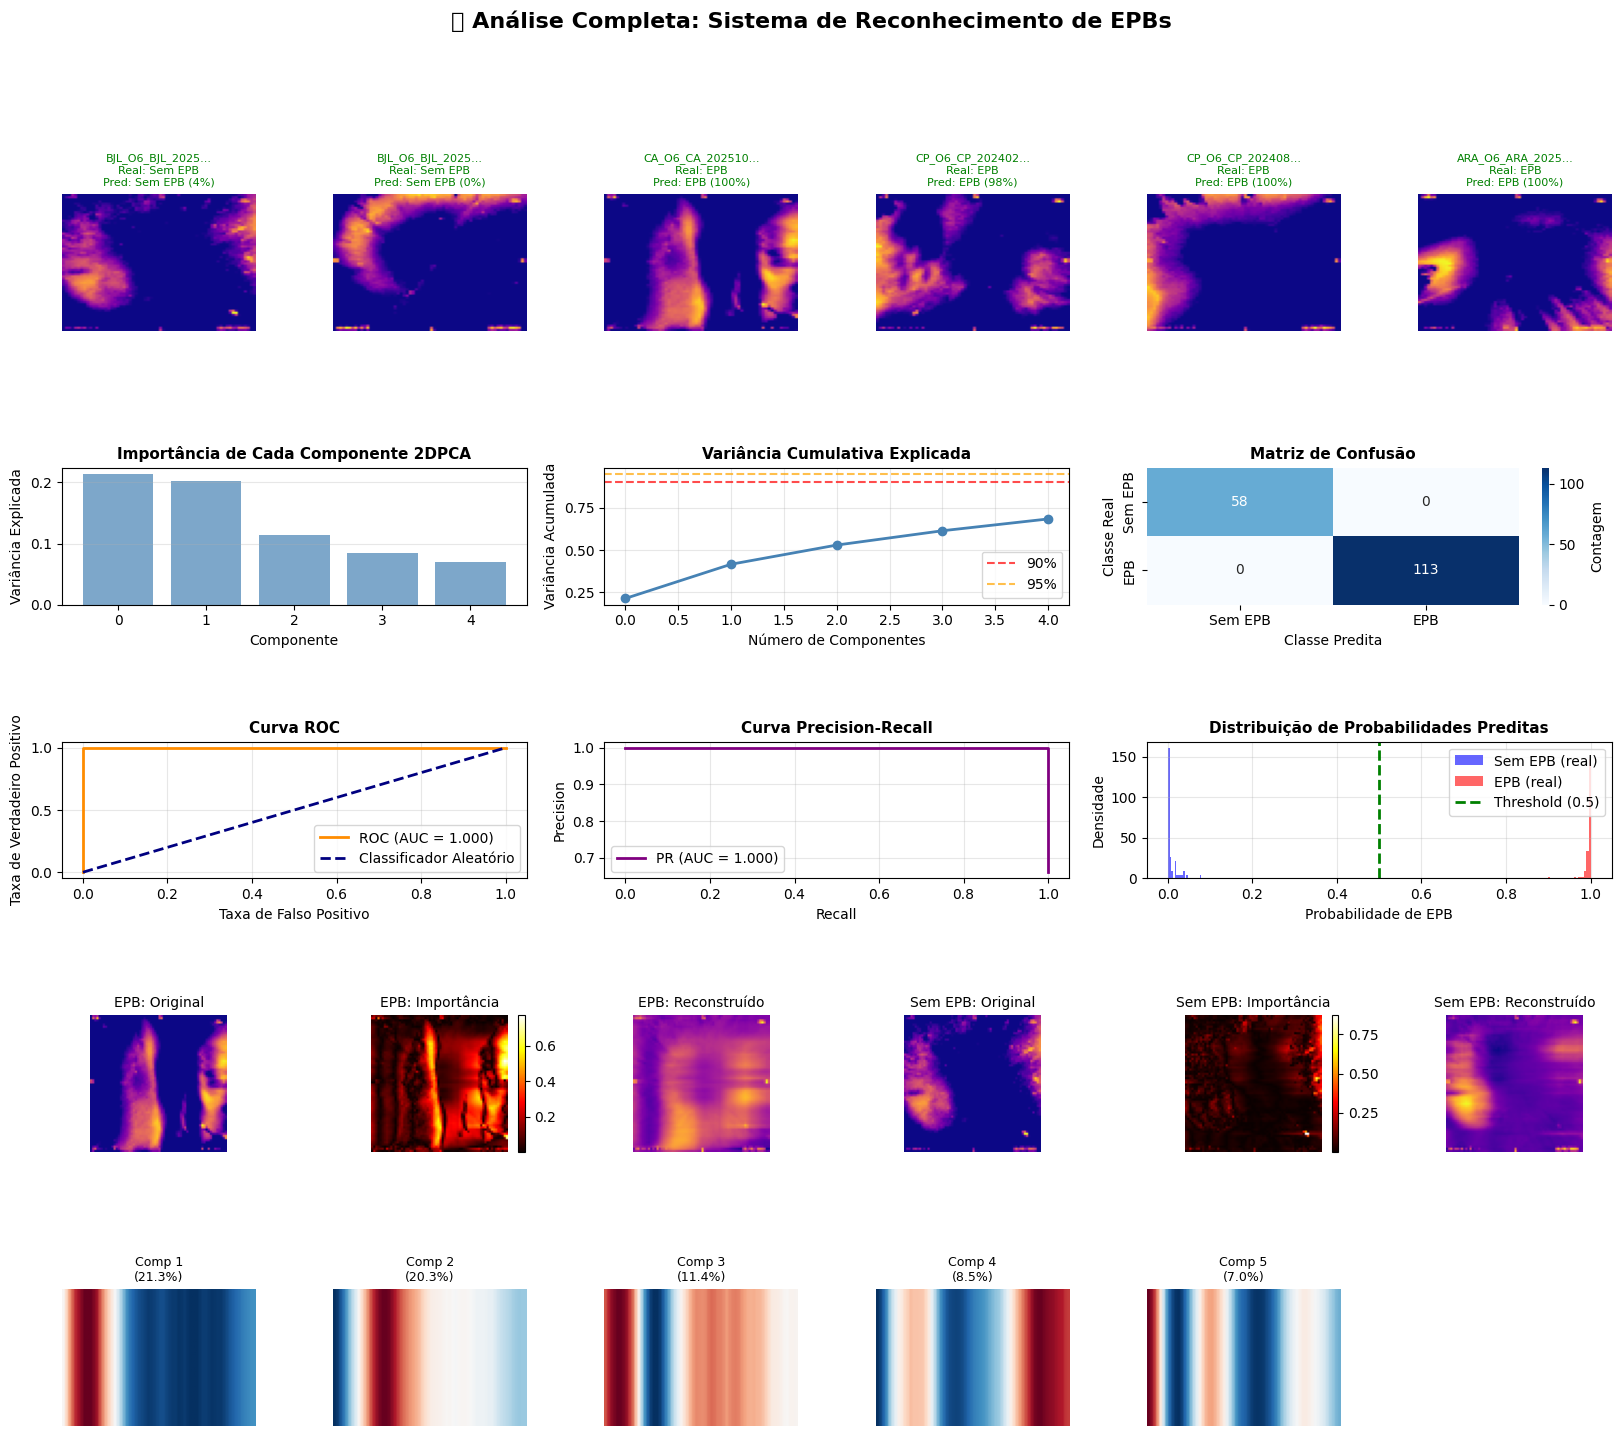

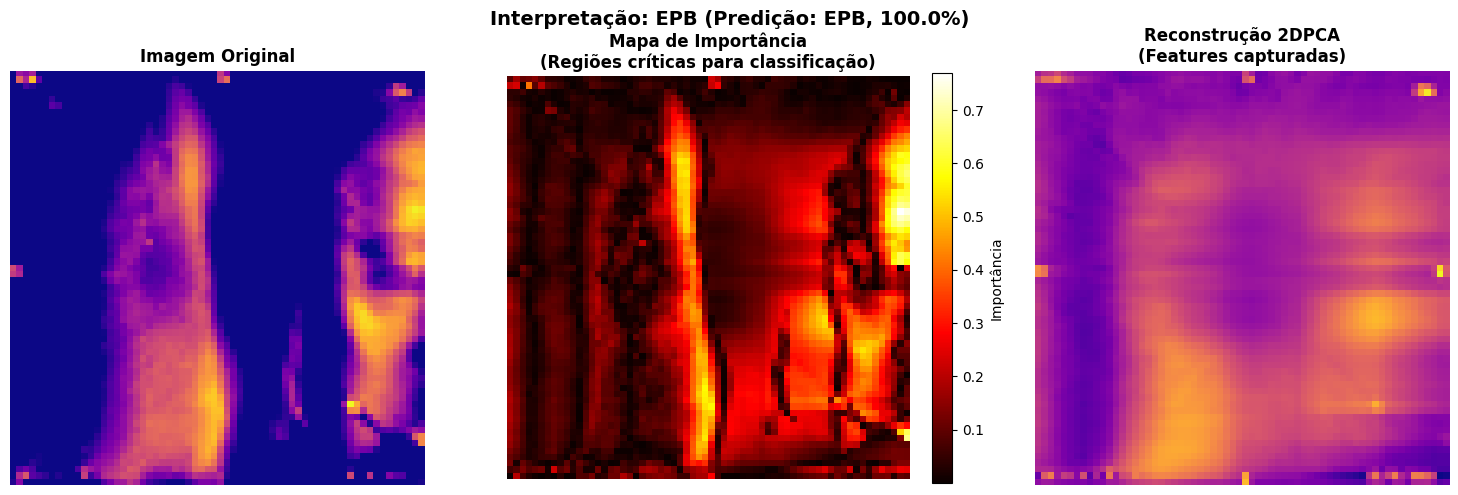


ETAPA 8: SALVAMENTO DO MODELO
   ✓ Modelo salvo: models/epb_recognition_model.pkl

✅ PIPELINE COMPLETO EXECUTADO COM SUCESSO!

✅ TREINAMENTO CONCLUÍDO COM SUCESSO!

� Próximas etapas sugeridas:

1. ANÁLISE DOS RESULTADOS:
    - Revise as visualizações geradas
    - Analise os casos de falso positivo/negativo
    - Valide com conhecimento do domínio

2. AJUSTE FINO (se necessário):
    - Ajuste threshold de probabilidade
    - Experimente diferentes n_components
    - Teste outros classificadores no ensemble

3. USO DO MODELO:
    - Use 'models/epb_recognition_model.pkl' para predições
    - Siga o guia de uso impresso acima
    - Monitore performance em produção



In [3]:
print("\n🌌 Iniciando sistema com dados reais de EPB...")
print(f"   📁 Pasta de imagens: epb/")
print(f"   📄 Arquivo de labels: epb_labels.csv\n")

system, X_test, y_test, y_pred, y_proba = pipeline()

print("\n" + "="*70)
print("✅ TREINAMENTO CONCLUÍDO COM SUCESSO!")
print("="*70)
print("""
� Próximas etapas sugeridas:

1. ANÁLISE DOS RESULTADOS:
    - Revise as visualizações geradas
    - Analise os casos de falso positivo/negativo
    - Valide com conhecimento do domínio

2. AJUSTE FINO (se necessário):
    - Ajuste threshold de probabilidade
    - Experimente diferentes n_components
    - Teste outros classificadores no ensemble

3. USO DO MODELO:
    - Use 'models/epb_recognition_model.pkl' para predições
    - Siga o guia de uso impresso acima
    - Monitore performance em produção
""")

## 📊 EXPLICAÇÃO DETALHADA DA VISUALIZAÇÃO GERADA

O dashboard de análise é dividido em **5 LINHAS**, cada uma com múltiplos gráficos:

---

### 📍 **LINHA 1: Exemplos de Classificação (6 imagens)**

**O que mostra:** 6 imagens de teste aleatórias com suas predições

**Elementos:**
- **Imagem:** Visualização da imagem EPB processada (colormap plasma)
- **Título verde:** Classificação CORRETA (predição = realidade)
- **Título vermelho:** Classificação INCORRETA (erro do modelo)
- **Informações:** 
  - `Real:` Classe verdadeira (EPB ou Sem EPB)
  - `Pred:` Classe predita pelo modelo
  - `(X%)` Probabilidade/confiança da predição

**Interpretação:** Permite visualizar rapidamente acertos e erros do modelo em casos reais.

---

### 📍 **LINHA 2: Análise de Features e Performance**

#### **Gráfico 1 (esquerda): Variância por Componente 2DPCA**
- **Eixo X:** Índice do componente (0, 1, 2, ...)
- **Eixo Y:** Variância explicada por cada componente
- **Barras azuis:** Quanto cada componente contribui para representar os dados
- **Interpretação:** Primeiros componentes capturam mais informação (barras maiores). Componentes finais capturam menos (podem ser ruído).

#### **Gráfico 2 (centro-esquerda): Variância Cumulativa**
- **Linha azul:** Soma acumulada da variância explicada
- **Linha vermelha tracejada:** 90% da variância
- **Linha laranja tracejada:** 95% da variância
- **Interpretação:** Mostra quantos componentes são necessários para capturar X% da informação. Ex: "Com 15 componentes, capturamos 92% da variância total".

#### **Gráfico 3 (direita): Matriz de Confusão**
- **Linhas:** Classe real (verdade)
- **Colunas:** Classe predita (modelo)
- **Células:**
  - **Superior esquerda (azul escuro):** Verdadeiros Negativos (VN) - Sem EPB, predito corretamente
  - **Inferior direita (azul escuro):** Verdadeiros Positivos (VP) - EPB, predito corretamente
  - **Superior direita:** Falsos Positivos (FP) - Predisse EPB, mas não tinha
  - **Inferior esquerda:** Falsos Negativos (FN) - Tinha EPB, mas não detectou
- **Interpretação:** Diagonal principal (azul escuro) = acertos. Fora da diagonal = erros.

---

### 📍 **LINHA 3: Métricas de Discriminação**

#### **Gráfico 1 (esquerda): Curva ROC**
- **Linha laranja:** Performance do modelo
- **Linha azul tracejada:** Classificador aleatório (50% de chance)
- **AUC (Area Under Curve):** Área sob a curva (quanto mais próximo de 1.0, melhor)
- **Eixo X:** Taxa de Falsos Positivos (FPR)
- **Eixo Y:** Taxa de Verdadeiros Positivos (TPR/Recall)
- **Interpretação:** 
  - AUC = 1.0: Modelo perfeito
  - AUC = 0.9-0.99: Excelente
  - AUC = 0.8-0.89: Bom
  - AUC = 0.5: Igual a sorte

#### **Gráfico 2 (centro): Curva Precision-Recall**
- **Linha roxa:** Trade-off entre precisão e recall
- **Eixo X:** Recall (sensibilidade - detecta EPBs reais)
- **Eixo Y:** Precision (confiança - evita falsos alarmes)
- **Interpretação:** Quanto mais próximo do canto superior direito, melhor o equilíbrio entre detectar EPBs e evitar falsos alarmes.

#### **Gráfico 3 (direita): Distribuição de Probabilidades**
- **Histograma azul:** Imagens SEM EPB - distribuição das probabilidades preditas
- **Histograma vermelho:** Imagens COM EPB - distribuição das probabilidades preditas
- **Linha verde vertical:** Threshold de decisão (0.5)
- **Interpretação:** 
  - Boa separação: histogramas bem separados (azul à esquerda, vermelho à direita)
  - Má separação: histogramas sobrepostos (modelo confuso)
  - À esquerda do threshold: predito como "Sem EPB"
  - À direita do threshold: predito como "EPB"

---

### 📍 **LINHA 4: Interpretação de Features (2 exemplos)**

Para cada classe (EPB e Sem EPB), mostra 3 imagens:

#### **Sequência 1: Exemplo de EPB**
1. **Original:** Imagem EPB real como foi capturada
2. **Mapa de Importância (hot colormap):**
   - **Vermelho/Amarelo:** Regiões mais importantes para classificação
   - **Azul/Preto:** Regiões menos relevantes
   - Mostra onde o modelo "olha" para decidir
3. **Reconstruído:** Imagem reconstruída pelos componentes 2DPCA
   - Compara com original para ver o que foi preservado/perdido

#### **Sequência 2: Exemplo de Sem EPB**
- Mesma estrutura acima, mas para uma imagem sem EPB
- Permite comparar quais regiões são importantes em cada classe

**Interpretação:** Valida se o modelo está focando em regiões fisicamente plausíveis para EPBs (estruturas verticais, deplecções de plasma).

---

### 📍 **LINHA 5: Componentes Principais Visualizados (6 componentes)**

**O que mostra:** Visualização dos primeiros 6 componentes principais do 2DPCA

**Cada subplot:**
- **Imagem:** Representação visual do componente (como um "filtro")
- **Título:** `Comp X (Y%)`
  - `X`: Índice do componente (1, 2, 3, ...)
  - `Y%`: Percentual de variância explicada por esse componente
- **Colormap RdBu_r:** 
  - Vermelho: valores positivos
  - Azul: valores negativos
  - Branco: valores próximos de zero

**Interpretação:** 
- Primeiros componentes (alta % variância): capturam padrões gerais, estrutura principal
- Componentes posteriores (baixa % variância): capturam detalhes finos, ruído
- Padrões verticais/horizontais: podem indicar características espaciais dos EPBs

---

## 🎯 **COMO INTERPRETAR O SISTEMA COMPLETO**

### ✅ **Sistema BOM:**
- Matriz de confusão: Diagonal forte (muitos VP e VN)
- ROC AUC: > 0.90
- Distribuição de probabilidades: Bem separada
- Mapa de importância: Foca em regiões plausíveis

### ⚠️ **Sistema PRECISA MELHORAR:**
- Matriz de confusão: Muitos FP ou FN
- ROC AUC: < 0.80
- Distribuição de probabilidades: Muito sobreposta
- Mapa de importância: Foca em regiões aleatórias/bordas

### 📌 **Métricas Críticas para EPBs:**
- **Sensitivity (Recall):** Alta → Detecta a maioria dos EPBs reais (evita perder eventos)
- **Specificity:** Alta → Evita falsos alarmes (não confunde ionosfera quieta com EPB)
- **Equilíbrio:** Ambos devem ser > 85% para aplicação científica confiável